In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [3]:
data=pd.read_csv('sepsis_data_cleaned.csv')

In [8]:
# Drop non-numeric or ID columns
X = data.drop(columns=['SepsisLabel', 'patient_id'])

# Target variable
y = data['SepsisLabel']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression

# Model 1: Imbalanced (default)
lr_imbalanced = LogisticRegression(random_state=42, max_iter=1000)
lr_imbalanced.fit(X_train_scaled, y_train)

# Model 2: Balanced
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_balanced.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(y_true, y_pred, y_proba, label):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    tpr = tp / (tp + fn)  # Recall
    fpr = fp / (fp + tn)  # False Positive Rate
    roc = roc_auc_score(y_true, y_proba)

    return {
        'Model': label,
        'Accuracy': accuracy,
        'TPR (Recall)': tpr,
        'FPR': fpr,
        'ROC AUC': roc
    }

In [26]:
results = []

results.append(evaluate_model(y_test, preds_imbalanced, probs_imbalanced, "Logistic Regression (Imbalanced)"))
results.append(evaluate_model(y_test, preds_balanced, probs_balanced, "Logistic Regression (Balanced)"))

results_df = pd.DataFrame(results)

In [28]:
results_df

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Logistic Regression (Imbalanced),0.982840,0.000628,0.000066,0.747827
1,Logistic Regression (Balanced),0.746604,0.650126,0.251716,0.752332


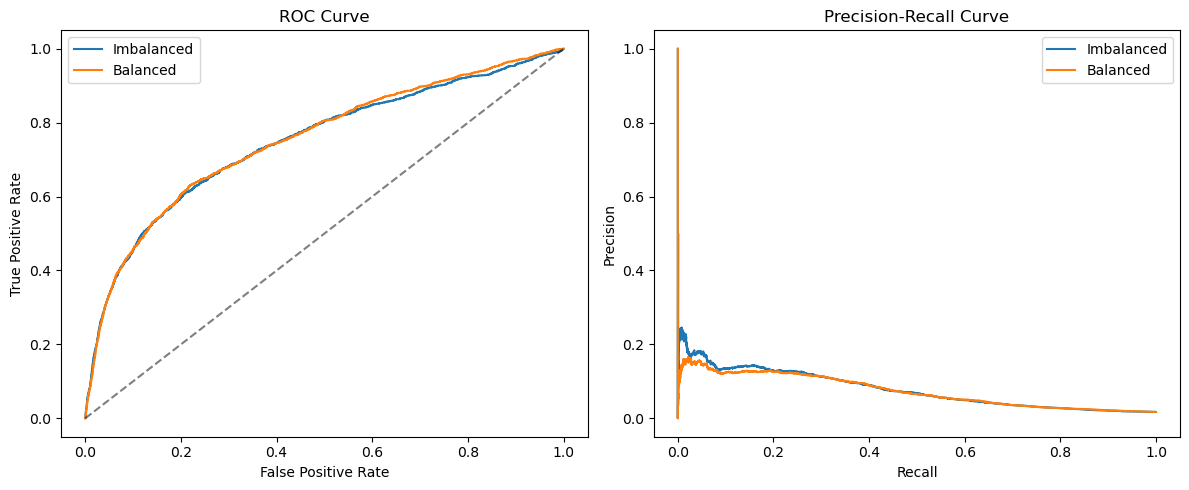

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Get curves
fpr_imb, tpr_imb, _ = roc_curve(y_test, probs_imbalanced)
fpr_bal, tpr_bal, _ = roc_curve(y_test, probs_balanced)

prec_imb, rec_imb, _ = precision_recall_curve(y_test, probs_imbalanced)
prec_bal, rec_bal, _ = precision_recall_curve(y_test, probs_balanced)

# Plotting
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_imb, tpr_imb, label='Imbalanced')
plt.plot(fpr_bal, tpr_bal, label='Balanced')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(rec_imb, prec_imb, label='Imbalanced')
plt.plot(rec_bal, prec_bal, label='Balanced')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

def get_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)  # Sensitivity / Recall
    fpr = fp / (fp + tn)  # Fall-out
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    return {"TPR": tpr, "FPR": fpr, "Accuracy": acc, "AUC": auc}

In [36]:
metrics_imbalanced = get_metrics(y_test, probs_imbalanced)
metrics_balanced = get_metrics(y_test, probs_balanced)

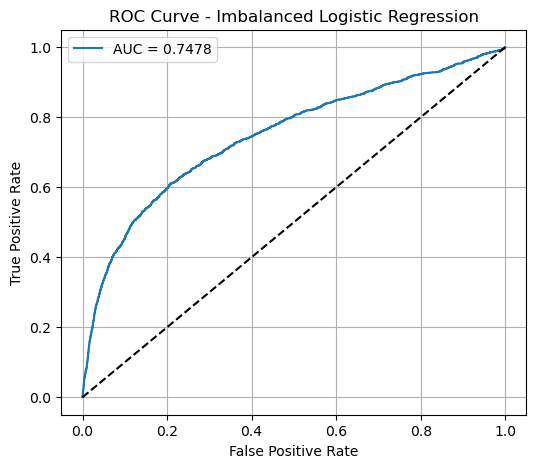

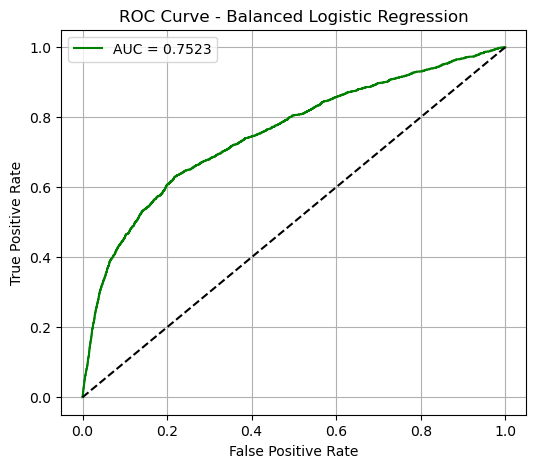

In [38]:
import matplotlib.pyplot as plt

# ROC Curve - Imbalanced
fpr_imb, tpr_imb, _ = roc_curve(y_test, probs_imbalanced)
plt.figure(figsize=(6, 5))
plt.plot(fpr_imb, tpr_imb, label=f"AUC = {metrics_imbalanced['AUC']:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Imbalanced Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve - Balanced
fpr_bal, tpr_bal, _ = roc_curve(y_test, probs_balanced)
plt.figure(figsize=(6, 5))
plt.plot(fpr_bal, tpr_bal, label=f"AUC = {metrics_balanced['AUC']:.4f}", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Balanced Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [44]:
# Function to train and evaluate model
def train_evaluate_rf(X_train, y_train, X_test, y_test, model_name):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_prob)
    
    results = {
        "model": model_name,
        "TPR": tpr,
        "FPR": fpr,
        "Accuracy": acc,
        "AUC": auc,
        "fpr_curve": fpr_curve,
        "tpr_curve": tpr_curve,
        "clf": clf
    }
    return results

In [50]:
# A. Imbalanced
imbalanced_results = train_evaluate_rf(X_train, y_train, X_test, y_test, "Imbalanced RF")

In [52]:
# B. Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
undersampled_results = train_evaluate_rf(X_train_rus, y_train_rus, X_test, y_test, "Under-Sampled RF")

In [54]:
# C. Random Over-Sampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
oversampled_results = train_evaluate_rf(X_train_ros, y_train_ros, X_test, y_test, "Over-Sampled RF")

In [56]:
# Collect all results
all_results = [imbalanced_results, undersampled_results, oversampled_results]

# Extract summary metrics from all RF models
for res in all_results:
    results.append({
        'Model': res["model"],
        'Accuracy': res["Accuracy"],
        'TPR (Recall)': res["TPR"],
        'FPR': res["FPR"],
        'ROC AUC': res["AUC"]
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

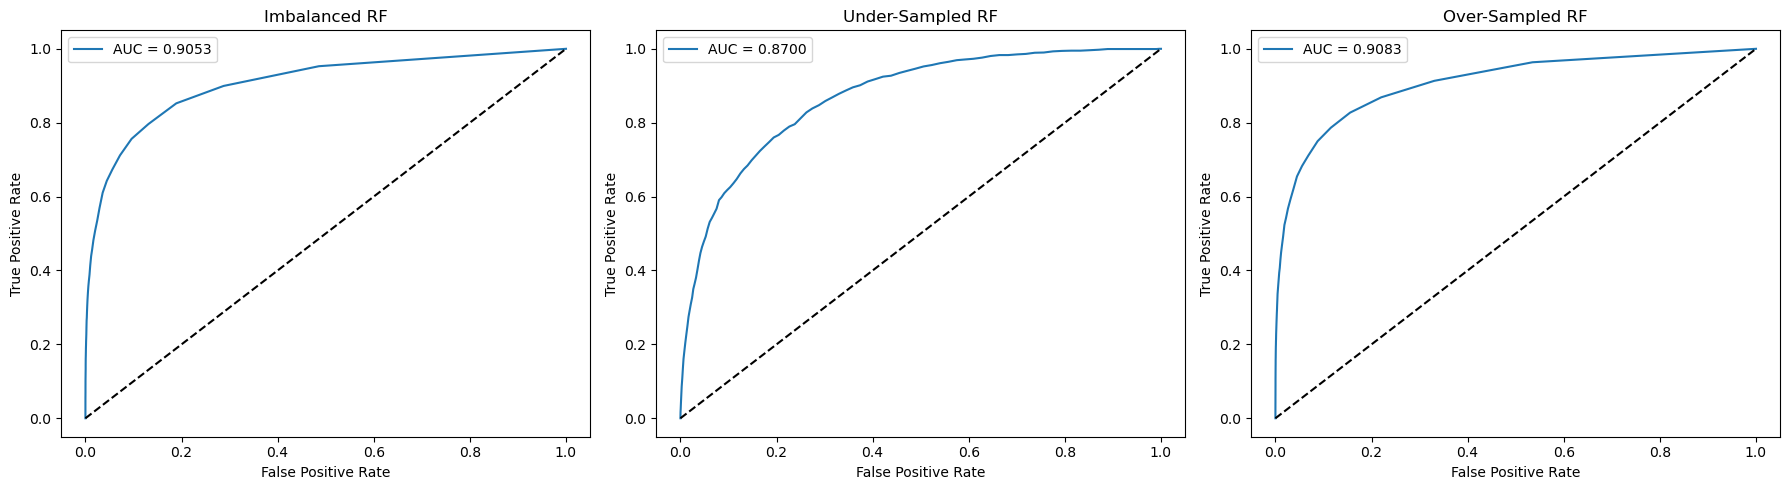

In [58]:
# Plot ROC curves
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, res in enumerate(all_results):
    axs[i].plot(res["fpr_curve"], res["tpr_curve"], label=f"AUC = {res['AUC']:.4f}")
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_title(res["model"])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    axs[i].legend()

plt.tight_layout()

In [60]:
results_df

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Logistic Regression (Imbalanced),0.982840,0.000628,0.000066,0.747827
1,Logistic Regression (Balanced),0.746604,0.650126,0.251716,0.752332
2,Imbalanced RF,0.983828,0.056533,0.000033,0.905303
3,Under-Sampled RF,0.784482,0.778894,0.215421,0.869978
4,Over-Sampled RF,0.984247,0.089824,0.000186,0.908269


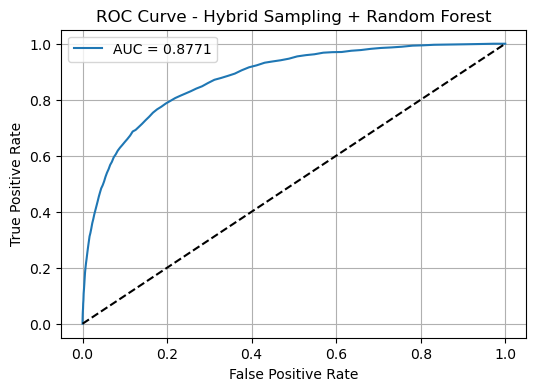

In [64]:
#Hybrid Sampling

from imblearn.over_sampling import SMOTE

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # retain more positive samples
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Step 4: Apply SMOTE to undersampled data
smote = SMOTE(random_state=42)
X_hybrid, y_hybrid = smote.fit_resample(X_rus, y_rus)

# Step 5: Train Random Forest
rf_hybrid = RandomForestClassifier(random_state=42)
rf_hybrid.fit(X_hybrid, y_hybrid)

# Step 6: Predictions and evaluation
y_pred_hybrid = rf_hybrid.predict(X_test)
y_proba_hybrid = rf_hybrid.predict_proba(X_test)[:, 1]

# Step 7: Confusion matrix and metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_hybrid).ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
auc = roc_auc_score(y_test, y_proba_hybrid)

# Store Hybrid RF results
results.append({
    'Model': 'Hybrid RF (RUS + SMOTE)',
    'Accuracy': accuracy,
    'TPR (Recall)': tpr,
    'FPR': fpr,
    'ROC AUC': auc
})

# Convert updated list to DataFrame
results_df = pd.DataFrame(results)

# Step 8: Plot ROC Curve
fpr_vals, tpr_vals, _ = roc_curve(y_test, y_proba_hybrid)
plt.figure(figsize=(6, 4))
plt.plot(fpr_vals, tpr_vals, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hybrid Sampling + Random Forest')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
results_df

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Logistic Regression (Imbalanced),0.982840,0.000628,0.000066,0.747827
1,Logistic Regression (Balanced),0.746604,0.650126,0.251716,0.752332
2,Imbalanced RF,0.983828,0.056533,0.000033,0.905303
3,Under-Sampled RF,0.784482,0.778894,0.215421,0.869978
4,Over-Sampled RF,0.984247,0.089824,0.000186,0.908269
5,Hybrid RF (RUS + SMOTE),0.871293,0.692211,0.125590,0.877055


## XGBoost 

In [73]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

In [75]:
def train_evaluate_xgb(X_train, y_train, X_test, y_test, model_name):
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_prob)
    
    results = {
        "model": model_name,
        "TPR": tpr,
        "FPR": fpr,
        "Accuracy": acc,
        "AUC": auc,
        "fpr_curve": fpr_curve,
        "tpr_curve": tpr_curve,
        "model": model
    }
    return results

In [77]:
#A Imbalanced 
imbalanced_xgb_results = train_evaluate_xgb(X_train, y_train, X_test, y_test, "Imbalanced XGBoost")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:08:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [79]:
# B. Random Under-Sampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

undersampled_xgb_results = train_evaluate_xgb(X_train_rus, y_train_rus, X_test, y_test, "Under-Sampled XGBoost")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:08:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


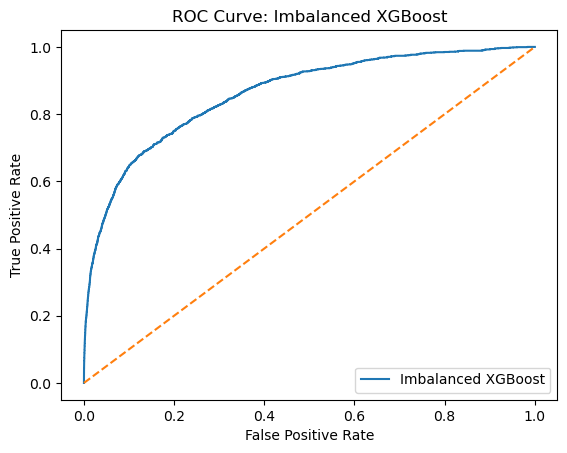

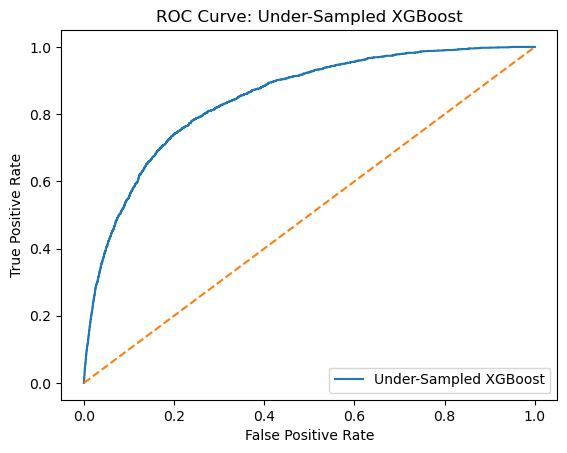

In [81]:
def plot_roc_curve(fpr, tpr, model_name):
    plt.plot(fpr, tpr, label=model_name)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Imbalanced XGBoost
plot_roc_curve(imbalanced_xgb_results['fpr_curve'], imbalanced_xgb_results['tpr_curve'], "Imbalanced XGBoost")

# Plot ROC for Under-Sampled XGBoost
plot_roc_curve(undersampled_xgb_results['fpr_curve'], undersampled_xgb_results['tpr_curve'], "Under-Sampled XGBoost")

In [83]:
#C Oversampled (SMOTE)
from imblearn.over_sampling import SMOTE

def train_evaluate_xgb_oversampled(X_train, y_train, X_test, y_test, model_name):
    # Apply SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train XGBoost model
    model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_smote, y_train_smote)
    
    # Predictions and evaluation
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_prob)
    
    results = {
        "model": model_name,
        "TPR": tpr,
        "FPR": fpr,
        "Accuracy": acc,
        "AUC": auc,
        "fpr_curve": fpr_curve,
        "tpr_curve": tpr_curve,
        "model": model
    }
    return results

In [85]:
# Apply SMOTE and train the XGBoost model on oversampled data
oversampled_xgb_results = train_evaluate_xgb_oversampled(X_train, y_train, X_test, y_test, "Oversampled XGBoost")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


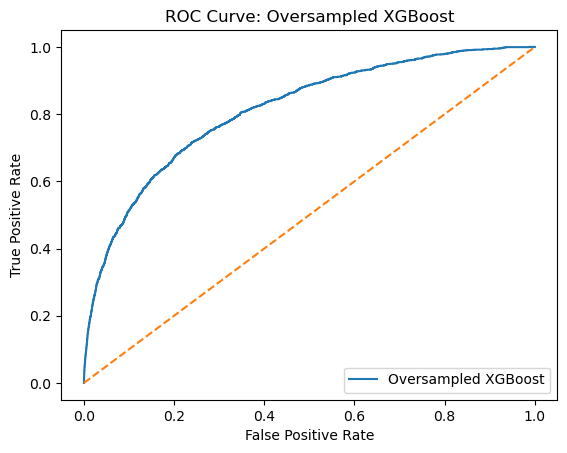

In [87]:
# Plot ROC for Oversampled XGBoost
plot_roc_curve(oversampled_xgb_results['fpr_curve'], oversampled_xgb_results['tpr_curve'], "Oversampled XGBoost")

In [95]:
# Append XGBoost results to the results list
results.append({
    'Model': 'Imbalanced XGBoost',
    'Accuracy': imbalanced_xgb_results["Accuracy"],
    'TPR (Recall)': imbalanced_xgb_results["TPR"],
    'FPR': imbalanced_xgb_results["FPR"],
    'ROC AUC': imbalanced_xgb_results["AUC"]
})

results.append({
    'Model': 'UnderSampled XGBoost',
    'Accuracy': undersampled_xgb_results["Accuracy"],
    'TPR (Recall)': undersampled_xgb_results["TPR"],
    'FPR': undersampled_xgb_results["FPR"],
    'ROC AUC': undersampled_xgb_results["AUC"]
})

results.append({
    'Model': 'OverSampled XGBoost',
    'Accuracy': oversampled_xgb_results["Accuracy"],
    'TPR (Recall)': oversampled_xgb_results["TPR"],
    'FPR': oversampled_xgb_results["FPR"],
    'ROC AUC': oversampled_xgb_results["AUC"]
})

In [97]:
results_df = pd.DataFrame(results)

In [101]:
# Keep only rows where 'Model' is a string (not a full model object)
results_df = results_df[results_df['Model'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

In [103]:
results_df

,Model,Accuracy,TPR (Recall),FPR,ROC AUC
0,Logistic Regression (Imbalanced),0.982840,0.000628,0.000066,0.747827
1,Logistic Regression (Balanced),0.746604,0.650126,0.251716,0.752332
2,Imbalanced RF,0.983828,0.056533,0.000033,0.905303
3,Under-Sampled RF,0.784482,0.778894,0.215421,0.869978
4,Over-Sampled RF,0.984247,0.089824,0.000186,0.908269
5,Hybrid RF (RUS + SMOTE),0.871293,0.692211,0.125590,0.877055
6,Imbalanced XGBoost,0.983484,0.058417,0.000415,0.861279
7,UnderSampled XGBoost,0.770717,0.765075,0.229185,0.846468
8,OverSampled XGBoost,0.978026,0.128141,0.007183,0.812896


In [68]:
#Out of all RF models, the undersampled RF is performing well: Our aim is to have higher TPR

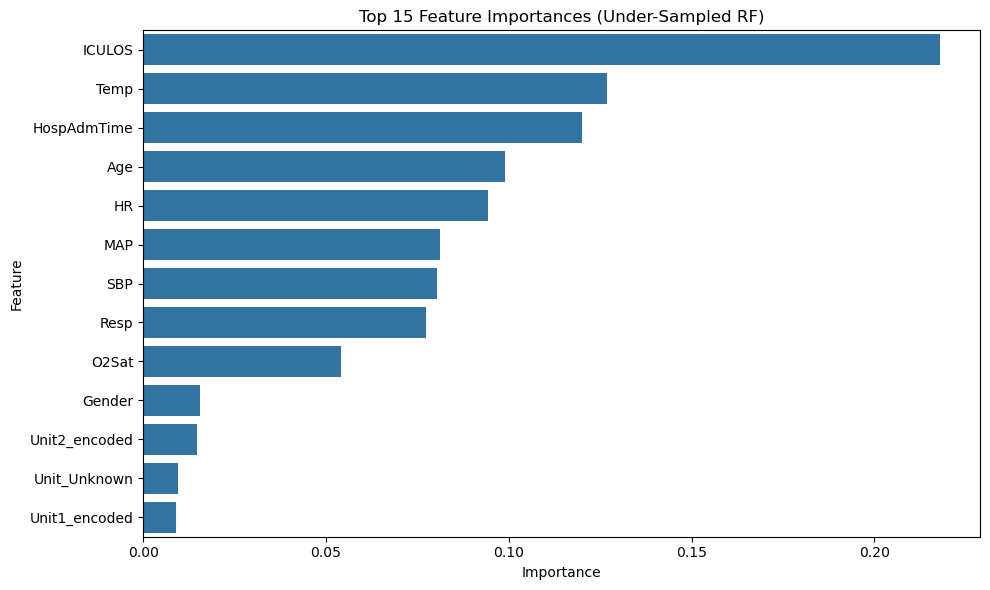

In [70]:
#Feature importance of this model:
# Get trained model from the results dictionary
rf_under = undersampled_results["clf"]

# Get feature importances
importances = rf_under.feature_importances_

# Get feature names
feature_names = X_train.columns  # assuming you didn't drop columns during resampling

# Create a DataFrame for easy sorting and visualization
import pandas as pd
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))  # top 15 features
plt.title('Top 15 Feature Importances (Under-Sampled RF)')
plt.tight_layout()
plt.show()

In [106]:
#store these results for further comparision
results_df.to_csv('results_df_ML.csv', index=False)